In [1]:
from typing import Dict
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import ellipj, ellipkinc, ellipeinc, ellipk
import cmath

In [2]:
def calcQ(P: float,bh_mass: float, tol=1e-3) ->float:
    Q=np.sqrt((P - 2.*bh_mass)*(P + 6.*bh_mass))
    return Q

def bfromP(P: float,bh_mass: float, tol: float=1e-5) ->float:
    b = np.sqrt(P**3/(P - 2.*bh_mass))
    return b

def zetainf(P: float,bh_mass: float, tol=1e-6) ->float:
    Q = calcQ(P,bh_mass)
    arg =(Q-P+2.*bh_mass)/(Q-P + 6.*bh_mass)
    z_inf = np.arcsin(np.sqrt(arg))
    return z_inf

def k(P: float,bh_mass: float) ->float:
    Q = calcQ(P,bh_mass)
    k = np.sqrt((Q-P+6*bh_mass)/(2*Q))
    return k

def k2(P: float,bh_mass: float) ->float:
    Q = calcQ(P,bh_mass)
    k2 = (Q-P+6*bh_mass)/(2*Q)
    return k2

def cosgamma(_a: float, incl: float, tol=1e-5) -> float:
    if abs(incl) <tol:
        return 0
    return np.cos(_a)/np.sqrt(np.cos(_a)**2+1/(np.tan(incl)**2))

def eq13(P: float, ir_radius: float,ir_angle: float, bh_mass: float,incl: float, n: int=0, tol=10e-6) -> float:
    z_inf = zetainf(P,bh_mass)
    Q = calcQ(P,bh_mass)
    m_ = k2(P,bh_mass)
    ell_inf = ellipkinc(z_inf,m_)
    g = np.arccos(cosgamma(ir_angle, incl))
    if n:
        ell_k = ellipk(m_)
        ellips_arg = (g-2.*n*np.pi)/(2.*np.sqrt(P/Q))-ell_inf+2.*ell_k
    else:
        ellips_arg=g/(2.*np.sqrt(P/Q)) +ell_inf
    sn,cn,dn,ph = ellipj(ellips_arg, m_)
    sn2 = sn*sn
    term1 = -(Q-P+2.*bh_mass)/(4.*bh_mass*P)
    term2 =((Q-P+6*bh_mass)/(4.*bh_mass*P))*sn2
    return 1.-ir_radius*(term1+term2)

def midpoint_method(func,args:Dict, __x,__y,__ind):
    new_x = __x
    new_y = __y
    x_ = [new_x[__ind],new_x[__ind+1]]
    inbetween_x = np.mean(x_)
    new_x.insert(__ind+1,inbetween_x)
    
    y_ = [new_y[__ind],new_y[__ind+1]]
    inbetween_solution = func(inbetween_x, **args)
    new_y.insert(__ind+1,inbetween_solution)
    y_.insert(1, inbetween_solution)
    ind_of_sign_change_ =np.where(np.diff(np.sign(y_)))[0]
    new_ind=__ind + ind_of_sign_change_[0]
    return new_x, new_y, new_ind

def improve_solutions_midpoint(func, args, x, y, index_of_sign_change, iterations) -> float:
    index_of_sign_change_ = index_of_sign_change
    new_x =x
    new_y =y
    new_ind = index_of_sign_change_
    for iteration in range(iterations):
        new_x, new_y, new_ind = midpoint_method(func=func, args=args, __x=new_x, __y=new_y, __ind = new_ind)
    updated_P = new_x[new_ind]
    return updated_P

def calcP(_r, incl, _alpha, bh_mass, midpoint_iterations =100, plot_inbetween=False, n=0, min_P=1., initial_guesses=20) -> float:
    def get_plot(X,Y,solution, radius=_r):
        fig=plt.figure()
        plt.title("eq13(P)\nr={}, a={}".format(radius, round(_alpha,5)))
        plt.xlabel('P')
        plt.ylabel('Eq13(P)')
        plt.axhline(0,color='black')
        plt.plot(X,Y)
        plt.scatter(solution, 0, color='red')
        return plt
    periastron_range =list(np.linspace(min_P, 2.*_r, initial_guesses))
    y_ = [eq13(P_value, _r,_alpha, bh_mass, incl, n) for P_value in periastron_range]
    ind=np.where(np.diff(np.sign(y_)))[0]
    periastron_solution = periastron_range[ind[0]] if len(ind) else None
    if(periastron_solution is not None) and (not np.isnan(periastron_solution)):
        args_eq13 ={"ir_radius":_r, "ir_angle":_alpha, "bh_mass":bh_mass, "incl":incl, "n":n}
        periastron_solution = \
        improve_solutions_midpoint(func=eq13, args=args_eq13, x=periastron_range,y=y_, index_of_sign_change=ind[0], iterations = midpoint_iterations)
    if plot_inbetween:
        get_plot(periastron_range, y_, periastron_solution).show
    return periastron_solution

def ellipse(r,a,incl):
    g=np.arccos(cosgamma(a,incl))
    b_=r*np.sin(g)
    return b_

def calcb(_r, incl, _alpha, bh_mass, midpoint_iterations, plot_inbetween, n, min_P, initial_guesses) -> float:
    periastron_solution = calcP(_r,incl,_alpha,bh_mass, midpoint_iterations, plot_inbetween,n,min_P,initial_guesses)
    if periastron_solution is None or periastron_solution <=2.*bh_mass:
        return ellipse(_r, _alpha,incl)
    elif periastron_solution >2.*bh_mass:
        b=bfromP(periastron_solution, bh_mass)
        return b
    else:
        raise ValueError("no solution was found for P ar (r,a)=({_r}, {_alpha}) and incl = {incl}")

In [3]:
def redshifteq(radius, angle, incl, bh_mass, midpoint_iterations, plot_inbetween, n, min_P, initial_guesses, z):
    b= calcb(radius, incl, angle, bh_mass, midpoint_iterations, plot_inbetween,n,min_P, initial_guesses)
    return (1.+np.sqrt(bh_mass/radius**3)*b*np.sin(incl)*np.sin(angle))/np.sqrt(1-3.*bh_mass/radius)-(1+z)

def constantredshift(incl, _alpha, bh_mass, z, min_r, midpoint_iterations =100, plot_inbetween = False, n=0, min_P=1., initial_guesses=20) -> float:
    radius_range =list(np.linspace(min_r, 120*bh_mass, initial_guesses))
    y_ = [redshifteq(r_value,_alpha, incl, bh_mass, midpoint_iterations, plot_inbetween, n, min_P, initial_guesses, z) for r_value in radius_range]
    ind=np.where(np.diff(np.sign(y_)))[0]
    radius_solution = radius_range[ind[0]] if len(ind) else None
    if(radius_solution is not None) and (not np.isnan(radius_solution)):
        args_redshifteq ={"angle":_alpha, "bh_mass":bh_mass, "incl":incl, "n":n, "z":z, "midpoint_iterations":midpoint_iterations,"plot_inbetween":plot_inbetween,"min_P":min_P,"initial_guesses":initial_guesses}
        radius_solution = \
        improve_solutions_midpoint(func=redshifteq, args=args_redshifteq, x=radius_range,y=y_, index_of_sign_change=ind[0], iterations = midpoint_iterations)
    return radius_solution

In [ ]:
alphas = np.linspace(0, 2*np.pi, 1000)
constantz_085_30 = np.empty(1000)
constantz_090_30 = np.empty(1000)
constantz_095_30 = np.empty(1000)
constantz_100_30 = np.empty(1000)
constantz_105_30 = np.empty(1000)
constantz_110_30 = np.empty(1000)
constantz_115_30 = np.empty(1000)
constantz_120_30 = np.empty(1000)
constantz_125_30 = np.empty(1000)
constantz_150_30 = np.empty(1000)
constantz_175_30 = np.empty(1000)

for i in range(0,1000):
    constantz_085_30[i]= constantredshift(np.pi/3, alphas[i], 1, -0.15, 3.001, 100, False, 0, 3.001, 20)
    constantz_090_30[i]= constantredshift(np.pi/3, alphas[i], 1, -0.1, 3.001, 100, False, 0, 3.001, 20)
    constantz_095_30[i]= constantredshift(np.pi/3, alphas[i], 1, -0.05, 3.001, 100, False, 0, 3.001, 20)
    constantz_100_30[i]= constantredshift(np.pi/3, alphas[i], 1, 0, 3.001, 100, False, 0, 3.001, 20)
    constantz_105_30[i]= constantredshift(np.pi/3, alphas[i], 1, 0.05, 3.001, 100, False,  0, 3.001, 20)
    constantz_110_30[i]= constantredshift(np.pi/3, alphas[i], 1, 0.1, 3.001, 100, False, 0, 3.001, 20)
    constantz_115_30[i]= constantredshift(np.pi/3, alphas[i], 1, 0.15, 3.001, 100, False, 0, 3.001, 20)
    constantz_120_30[i]= constantredshift(np.pi/3, alphas[i], 1, 0.2, 3.001, 100, False, 0, 3.001, 20)
    constantz_125_30[i]= constantredshift(np.pi/3, alphas[i], 1, 0.25, 3.001, 100, False, 0, 3.001, 20)
    constantz_150_30[i]= constantredshift(np.pi/3, alphas[i], 1, 0.5, 3.001, 100, False, 0, 3.001, 20)
    constantz_175_30[i]= constantredshift(np.pi/3, alphas[i], 1, 0.75, 3.001, 100, False, 0, 3.001, 20)
    
plt.figure(figsize=(6,6))
ax = plt.subplot(111,polar=True)
ax.plot(alphas, constantz_085_30, color= 'black', label="$z=-0.15$")
ax.plot(alphas, constantz_090_30, color= 'purple', label="$z=-0.10$")
ax.plot(alphas, constantz_095_30, color= 'blue', label="$z=-0.05$")
ax.plot(alphas, constantz_100_30, color= 'green', label="$z=0$")
ax.plot(alphas, constantz_105_30, color= 'red', label="$z=0.05$")
ax.plot(alphas, constantz_110_30, color= 'orange', label="$z=0.10$")
ax.plot(alphas, constantz_115_30, color= 'brown', label="$z=0.15$")
ax.plot(alphas, constantz_120_30, color= 'pink', label="$z=0.20$")
ax.plot(alphas, constantz_125_30, color= 'grey', label="$z=0.25$")
ax.plot(alphas, constantz_150_30, color= 'olive', label="$z=0.50$")
ax.plot(alphas, constantz_175_30, color= 'cyan', label="$z=0.75$")
plt.legend()
plt.show()

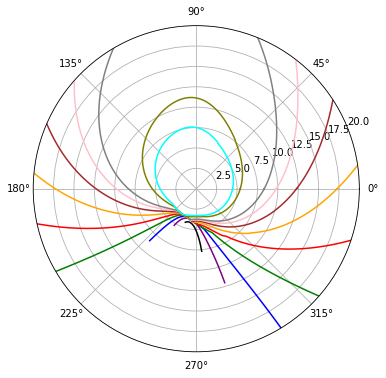

In [64]:
plt.figure(figsize=(6,6))
ax = plt.subplot(111,polar=True)
ax.set_rlim(0,20)
ax.plot(alphas, constantz_085_30, color= 'black', label="$z=-0.15$")
ax.plot(alphas, constantz_090_30, color= 'purple', label="$z=-0.10$")
ax.plot(alphas, constantz_095_30, color= 'blue', label="$z=-0.05$")
ax.plot(alphas, constantz_100_30, color= 'green', label="$z=0$")
ax.plot(alphas, constantz_105_30, color= 'red', label="$z=0.05$")
ax.plot(alphas, constantz_110_30, color= 'orange', label="$z=0.10$")
ax.plot(alphas, constantz_115_30, color= 'brown', label="$z=0.15$")
ax.plot(alphas, constantz_120_30, color= 'pink', label="$z=0.20$")
ax.plot(alphas, constantz_125_30, color= 'grey', label="$z=0.25$")
ax.plot(alphas, constantz_150_30, color= 'olive', label="$z=0.50$")
ax.plot(alphas, constantz_175_30, color= 'cyan', label="$z=0.75$")
plt.show()

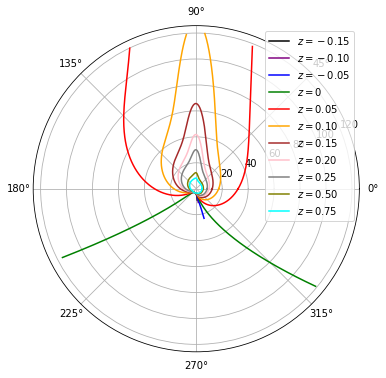

In [4]:
alphas = np.linspace(0, 2*np.pi, 1000)
constantz_085_10 = np.empty(1000)
constantz_090_10 = np.empty(1000)
constantz_095_10 = np.empty(1000)
constantz_100_10 = np.empty(1000)
constantz_105_10 = np.empty(1000)
constantz_110_10 = np.empty(1000)
constantz_115_10 = np.empty(1000)
constantz_120_10 = np.empty(1000)
constantz_125_10 = np.empty(1000)
constantz_150_10 = np.empty(1000)
constantz_175_10 = np.empty(1000)

for i in range(0,1000):
    constantz_085_10[i]= constantredshift(4*np.pi/9, alphas[i], 1, -0.15, 3.001, 100, False, 0, 3.001, 20)
    constantz_090_10[i]= constantredshift(4*np.pi/9, alphas[i], 1, -0.1, 3.001, 100, False, 0, 3.001, 20)
    constantz_095_10[i]= constantredshift(4*np.pi/9, alphas[i], 1, -0.05, 3.001, 100, False, 0, 3.001, 20)
    constantz_100_10[i]= constantredshift(4*np.pi/9, alphas[i], 1, 0, 3.001, 100, False, 0, 3.001, 20)
    constantz_105_10[i]= constantredshift(4*np.pi/9, alphas[i], 1, 0.05, 3.001, 100, False,  0, 3.001, 20)
    constantz_110_10[i]= constantredshift(4*np.pi/9, alphas[i], 1, 0.1, 3.001, 100, False, 0, 3.001, 20)
    constantz_115_10[i]= constantredshift(4*np.pi/9, alphas[i], 1, 0.15, 3.001, 100, False, 0, 3.001, 20)
    constantz_120_10[i]= constantredshift(4*np.pi/9, alphas[i], 1, 0.2, 3.001, 100, False, 0, 3.001, 20)
    constantz_125_10[i]= constantredshift(4*np.pi/9, alphas[i], 1, 0.25, 3.001, 100, False, 0, 3.001, 20)
    constantz_150_10[i]= constantredshift(4*np.pi/9, alphas[i], 1, 0.5, 3.001, 100, False, 0, 3.001, 20)
    constantz_175_10[i]= constantredshift(4*np.pi/9, alphas[i], 1, 0.75, 3.001, 100, False, 0, 3.001, 20)
    
plt.figure(figsize=(6,6))
ax = plt.subplot(111,polar=True)
ax.plot(alphas, constantz_085_10, color= 'black', label="$z=-0.15$")
ax.plot(alphas, constantz_090_10, color= 'purple', label="$z=-0.10$")
ax.plot(alphas, constantz_095_10, color= 'blue', label="$z=-0.05$")
ax.plot(alphas, constantz_100_10, color= 'green', label="$z=0$")
ax.plot(alphas, constantz_105_10, color= 'red', label="$z=0.05$")
ax.plot(alphas, constantz_110_10, color= 'orange', label="$z=0.10$")
ax.plot(alphas, constantz_115_10, color= 'brown', label="$z=0.15$")
ax.plot(alphas, constantz_120_10, color= 'pink', label="$z=0.20$")
ax.plot(alphas, constantz_125_10, color= 'grey', label="$z=0.25$")
ax.plot(alphas, constantz_150_10, color= 'olive', label="$z=0.50$")
ax.plot(alphas, constantz_175_10, color= 'cyan', label="$z=0.75$")
plt.legend()
plt.show()

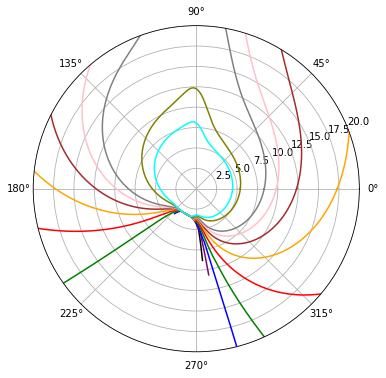

In [5]:
plt.figure(figsize=(6,6))
ax = plt.subplot(111,polar=True)
ax.set_rlim(0,20)
ax.plot(alphas, constantz_085_10, color= 'black', label="$z=-0.15$")
ax.plot(alphas, constantz_090_10, color= 'purple', label="$z=-0.10$")
ax.plot(alphas, constantz_095_10, color= 'blue', label="$z=-0.05$")
ax.plot(alphas, constantz_100_10, color= 'green', label="$z=0$")
ax.plot(alphas, constantz_105_10, color= 'red', label="$z=0.05$")
ax.plot(alphas, constantz_110_10, color= 'orange', label="$z=0.10$")
ax.plot(alphas, constantz_115_10, color= 'brown', label="$z=0.15$")
ax.plot(alphas, constantz_120_10, color= 'pink', label="$z=0.20$")
ax.plot(alphas, constantz_125_10, color= 'grey', label="$z=0.25$")
ax.plot(alphas, constantz_150_10, color= 'olive', label="$z=0.50$")
ax.plot(alphas, constantz_175_10, color= 'cyan', label="$z=0.75$")
plt.show()

In [4]:
def correction(P: float, bh_mass: float, ir_radius: float) -> float:
    b = bfromP(P, bh_mass)
    h = (((b**2+6*cmath.sqrt(81-3*b**2)-54)*b)**(1/3))/b
    a1 = (((b**2+6*cmath.sqrt(81-3*b**2)-54)*b)**(1/3))/b
    a2 = 1/3*(cmath.sqrt(complex(0,-3/(h-1/h)*(complex(1/ir_radius+h/2+1/(2*h)-1,np.sqrt(3)/2*(h-1/h))))))
    a3 = cmath.sqrt(complex(0,2*np.sqrt(3)/complex(3*h+3/h,np.sqrt(3)*(h-1/h))))
    a4 = 1/cmath.sqrt(2/(ir_radius**3) -1/(ir_radius**2)+1/(b**2))
    a5 = (h/6 +1/(6*h)+1/6)
    a6 = cmath.sqrt(-((1/ir_radius+h/12+1/(12*h)-1/6)**2+3/4*(h/6-1/(6*h))**2)*(1/ir_radius-a5)/complex(h/4+1/(4*h),np.sqrt(3)/2*(h/6-1/(6*h))))
    a7 = cmath.sqrt(-((1/ir_radius+h/12+1/(12*h)-1/6)**2+3/4*(h/6-1/(6*h))**2)*(1/ir_radius-a5)*complex(h/4+1/(4*h),np.sqrt(3)/2*(h/6-1/(6*h))))
    a8 = a4*ellipkinc(a2.real,a3.real)*(a6*(complex(0,4*np.sqrt(3)*((b**2+60)/(b**-27))/(3*b**2))+complex(0,32*np.sqrt(3)/(5*b**2)))+a5*(1/45-2/(3*b**2)+a5/(15*b**4)))
    a9 = a4*ellipeinc(a2.real,a3.real)*(a6*(112*np.sqrt(3)/45)+a7*complex(0,(4*np.sqrt(3)*(b**2+4)/(15*b**4))-4*np.sqrt(3)*(11*b**2-36)/(3*b**2*(b**2-27))))
    a10 = 2*(2*a4*(11*b**2-36)/ir_radius**2-(b**2+60)/ir_radius-b**2+2)/(b**2*(b**2-27))
    a11= 56/(15*a4)
    a12 = 8/(5*ir_radius*a4)
    a02 = 1/3*(cmath.sqrt(complex(0,-3/(h-1/h)*(complex(h/2+1/(2*h)-1,np.sqrt(3)/2*(h-1/h))))))
    a06 = cmath.sqrt(((h/12+1/(12*h)-1/6)**2+3/4*(h/6-1/(6*h))**2)*a5/complex(h/4+1/(4*h),np.sqrt(3)/2*(h/6-1/(6*h))))
    a07 = cmath.sqrt(((h/12+1/(12*h)-1/6)**2+3/4*(h/6-1/(6*h))**2)*a5*complex(h/4+1/(4*h),np.sqrt(3)/2*(h/6-1/(6*h))))
    a08 = a4*ellipkinc(a02.real,a3.real)*(a06*complex(0,(4*np.sqrt(3)*((b**2+60)/(b**-27))/(3*b**2))+32*np.sqrt(3)/(5*b**2))+a5*(1/45-2/(3*b**2)+a5/(15*b**4)))
    a09 = a4*ellipeinc(a02.real,a3.real)*(a06*(112*np.sqrt(3)/45)+a07*complex(0,(4*np.sqrt(3)*(b**2+4)/(15*b**4))-4*np.sqrt(3)*(11*b**2-36)/(3*b**2*(b**2-27))))
    a010 = 2*(b**2-2)/(b*(b**2-27))
    a011 = 56/(15*b)
    I = a8+a9+a10+a11+a12-b*a08-b*a09-a010-a011
    if np.isnan(I.real):
        return 1
    else:
        return I.real

def correctedeq13(P: float, ir_radius: float,ir_angle: float, bh_mass: float,incl: float, n: int=0, midpoint_iterations =100, plot_inbetween = False, min_P=3.001, initial_guesses=20, tol=10e-6) -> float:
    z_inf = zetainf(P,bh_mass)
    Q = calcQ(P,bh_mass)
    m_ = k2(P,bh_mass)
    ell_inf = ellipkinc(z_inf,m_)
    g = np.arccos(cosgamma(ir_angle, incl))
    I = correction(P, bh_mass, ir_radius)
    if n:
        ell_k = ellipk(m_)
        ellips_arg = (g-0.01*I-2.*n*np.pi)/(2.*np.sqrt(P/Q))-ell_inf+2.*ell_k
    else:
        ellips_arg=(g+0.01*I)/(2.*np.sqrt(P/Q)) +ell_inf
    sn,cn,dn,ph = ellipj(ellips_arg, m_)
    sn2 = sn*sn
    term1 = -(Q-P+2.*bh_mass)/(4.*bh_mass*P)
    term2 =((Q-P+6*bh_mass)/(4.*bh_mass*P))*sn2
    return 1.-ir_radius*(term1+term2)
                                                                                                                      
def calccorrectedP(_r, incl, _alpha, bh_mass, midpoint_iterations =100, plot_inbetween=False, n=0, min_P=1., initial_guesses=20) -> float:
    def get_plot(X,Y,solution, radius=_r):
        fig=plt.figure()
        plt.title("correctedeq13(P)\nr={}, a={}".format(radius, round(_alpha,5)))
        plt.xlabel('P')
        plt.ylabel('CorrectedEq13(P)')
        plt.axhline(0,color='black')
        plt.plot(X,Y)
        plt.scatter(solution, 0, color='red')
        return plt
    periastron_range =list(np.linspace(min_P, 2.*_r, initial_guesses))
    y_ = [correctedeq13(P_value, _r,_alpha, bh_mass, incl, n) for P_value in periastron_range]
    ind=np.where(np.diff(np.sign(y_)))[0]
    periastron_solution = periastron_range[ind[0]] if len(ind) else None
    if(periastron_solution is not None) and (not np.isnan(periastron_solution)):
        args_eq13 ={"ir_radius":_r, "ir_angle":_alpha, "bh_mass":bh_mass, "incl":incl, "n":n}
        periastron_solution = \
        improve_solutions_midpoint(func=correctedeq13, args=args_eq13, x=periastron_range,y=y_, index_of_sign_change=ind[0], iterations = midpoint_iterations)
    if plot_inbetween:
        get_plot(periastron_range, y_, periastron_solution).show
    return periastron_solution
                                                                                                                    
def calccorrectedb(_r, incl, _alpha, bh_mass, midpoint_iterations, plot_inbetween, n, min_P, initial_guesses) -> float:
    periastron_solution = calccorrectedP(_r,incl,_alpha,bh_mass, midpoint_iterations, plot_inbetween,n,min_P,initial_guesses)
    if periastron_solution is None or periastron_solution <=2.*bh_mass:
        return ellipse(_r, _alpha,incl)
    elif periastron_solution >2.*bh_mass:
        b=bfromP(periastron_solution, bh_mass)
        return b
    else:
        raise ValueError("no solution was found for P ar (r,a)=({_r}, {_alpha}) and incl = {incl}")

In [5]:
def correctedredshifteq(radius, angle, incl, bh_mass, midpoint_iterations, plot_inbetween, n, min_P, initial_guesses, z):
    b= calccorrectedb(radius, incl, angle, bh_mass, midpoint_iterations, plot_inbetween,n,min_P, initial_guesses)
    return (1.+np.sqrt(bh_mass/radius**3)*b*np.sin(incl)*np.sin(angle))/np.sqrt(1-3.*bh_mass/radius)-(1+z)

def constantcorrectedredshift(incl, _alpha, bh_mass, z, min_r, midpoint_iterations =100, plot_inbetween = False, n=0, min_P=1., initial_guesses=20) -> float:
    radius_range =list(np.linspace(min_r, 120*bh_mass, initial_guesses))
    y_ = [correctedredshifteq(r_value,_alpha, incl, bh_mass, midpoint_iterations, plot_inbetween, n, min_P, initial_guesses, z) for r_value in radius_range]
    ind=np.where(np.diff(np.sign(y_)))[0]
    radius_solution = radius_range[ind[0]] if len(ind) else None
    if(radius_solution is not None) and (not np.isnan(radius_solution)):
        args_redshifteq ={"angle":_alpha, "bh_mass":bh_mass, "incl":incl, "n":n, "z":z, "midpoint_iterations":midpoint_iterations,"plot_inbetween":plot_inbetween,"min_P":min_P,"initial_guesses":initial_guesses}
        radius_solution = \
        improve_solutions_midpoint(func=correctedredshifteq, args=args_redshifteq, x=radius_range,y=y_, index_of_sign_change=ind[0], iterations = midpoint_iterations)
    return radius_solution

In [ ]:
alphas = np.linspace(0, 2*np.pi, 1000)

constantz_085_30 = np.empty(1000)
constantz_090_30 = np.empty(1000)
constantz_095_30 = np.empty(1000)
constantz_100_30 = np.empty(1000)
constantz_105_30 = np.empty(1000)
constantz_110_30 = np.empty(1000)
constantz_115_30 = np.empty(1000)
constantz_120_30 = np.empty(1000)
constantz_125_30 = np.empty(1000)
constantz_150_30 = np.empty(1000)
constantz_175_30 = np.empty(1000)

for i in range(0,1000):
    constantz_085_30[i]= constantredshift(np.pi/3, alphas[i], 1, -0.15, 3.001, 100, False, 0, 3.001, 20)
    constantz_090_30[i]= constantredshift(np.pi/3, alphas[i], 1, -0.1, 3.001, 100, False, 0, 3.001, 20)
    constantz_095_30[i]= constantredshift(np.pi/3, alphas[i], 1, -0.05, 3.001, 100, False, 0, 3.001, 20)
    constantz_100_30[i]= constantredshift(np.pi/3, alphas[i], 1, 0, 3.001, 100, False, 0, 3.001, 20)
    constantz_105_30[i]= constantredshift(np.pi/3, alphas[i], 1, 0.05, 3.001, 100, False,  0, 3.001, 20)
    constantz_110_30[i]= constantredshift(np.pi/3, alphas[i], 1, 0.1, 3.001, 100, False, 0, 3.001, 20)
    constantz_115_30[i]= constantredshift(np.pi/3, alphas[i], 1, 0.15, 3.001, 100, False, 0, 3.001, 20)
    constantz_120_30[i]= constantredshift(np.pi/3, alphas[i], 1, 0.2, 3.001, 100, False, 0, 3.001, 20)
    constantz_125_30[i]= constantredshift(np.pi/3, alphas[i], 1, 0.25, 3.001, 100, False, 0, 3.001, 20)
    constantz_150_30[i]= constantredshift(np.pi/3, alphas[i], 1, 0.5, 3.001, 100, False, 0, 3.001, 20)
    constantz_175_30[i]= constantredshift(np.pi/3, alphas[i], 1, 0.75, 3.001, 100, False, 0, 3.001, 20)

corrected_constantz_085_30 = np.empty(1000)
corrected_constantz_090_30 = np.empty(1000)
corrected_constantz_095_30 = np.empty(1000)
corrected_constantz_100_30 = np.empty(1000)
corrected_constantz_105_30 = np.empty(1000)
corrected_constantz_110_30 = np.empty(1000)
corrected_constantz_115_30 = np.empty(1000)
corrected_constantz_120_30 = np.empty(1000)
corrected_constantz_125_30 = np.empty(1000)
corrected_constantz_150_30 = np.empty(1000)
corrected_constantz_175_30 = np.empty(1000)

for i in range(0,1000):
    corrected_constantz_085_30[i]= constantcorrectedredshift(np.pi/3, alphas[i], 1, -0.15, 3.001, 100, False, 0, 3.001, 20)
    corrected_constantz_090_30[i]= constantcorrectedredshift(np.pi/3, alphas[i], 1, -0.1, 3.001, 100, False, 0, 3.001, 20)
    corrected_constantz_095_30[i]= constantcorrectedredshift(np.pi/3, alphas[i], 1, -0.05, 3.001, 100, False, 0, 3.001, 20)
    corrected_constantz_100_30[i]= constantcorrectedredshift(np.pi/3, alphas[i], 1, 0, 3.001, 100, False, 0, 3.001, 20)
    corrected_constantz_105_30[i]= constantcorrectedredshift(np.pi/3, alphas[i], 1, 0.05, 3.001, 100, False,  0, 3.001, 20)
    corrected_constantz_110_30[i]= constantcorrectedredshift(np.pi/3, alphas[i], 1, 0.1, 3.001, 100, False, 0, 3.001, 20)
    corrected_constantz_115_30[i]= constantcorrectedredshift(np.pi/3, alphas[i], 1, 0.15, 3.001, 100, False, 0, 3.001, 20)
    corrected_constantz_120_30[i]= constantcorrectedredshift(np.pi/3, alphas[i], 1, 0.2, 3.001, 100, False, 0, 3.001, 20)
    corrected_constantz_125_30[i]= constantcorrectedredshift(np.pi/3, alphas[i], 1, 0.25, 3.001, 100, False, 0, 3.001, 20)
    corrected_constantz_150_30[i]= constantcorrectedredshift(np.pi/3, alphas[i], 1, 0.5, 3.001, 100, False, 0, 3.001, 20)
    corrected_constantz_175_30[i]= constantcorrectedredshift(np.pi/3, alphas[i], 1, 0.75, 3.001, 100, False, 0, 3.001, 20)
    
plt.figure(figsize=(6,6))
ax = plt.subplot(111,polar=True)
ax.plot(alphas, constantz_085_30, color= 'red')
ax.plot(alphas, constantz_090_30, color= 'red')
ax.plot(alphas, constantz_095_30, color= 'red')
ax.plot(alphas, constantz_100_30, color= 'red')
ax.plot(alphas, constantz_105_30, color= 'red')
ax.plot(alphas, constantz_110_30, color= 'red')
ax.plot(alphas, constantz_115_30, color= 'red')
ax.plot(alphas, constantz_120_30, color= 'red')
ax.plot(alphas, constantz_125_30, color= 'red')
ax.plot(alphas, constantz_150_30, color= 'red')
ax.plot(alphas, constantz_175_30, color= 'red')
ax.plot(alphas, corrected_constantz_085_30, color= 'blue')
ax.plot(alphas, corrected_constantz_090_30, color= 'blue')
ax.plot(alphas, corrected_constantz_095_30, color= 'blue')
ax.plot(alphas, corrected_constantz_100_30, color= 'blue')
ax.plot(alphas, corrected_constantz_105_30, color= 'blue')
ax.plot(alphas, corrected_constantz_110_30, color= 'blue')
ax.plot(alphas, corrected_constantz_115_30, color= 'blue')
ax.plot(alphas, corrected_constantz_120_30, color= 'blue')
ax.plot(alphas, corrected_constantz_125_30, color= 'blue')
ax.plot(alphas, corrected_constantz_150_30, color= 'blue')
ax.plot(alphas, corrected_constantz_175_30, color= 'blue')
plt.legend()
plt.show()